# How to - Basic Neuropixels Analysis

## Getting started

In the text file (`mouse_config.txt`) define for each recording where all relevant data is located,
using the following format:

```
MOUSE: DL159
SL_PATH: /Volumes/T8/Data/Neuropixels/DL159/DL159_7721n1
NP_PATH: /Volumes/T8/Data/Neuropixels/DL159
TR_PATH: /Volumes/T8/Data/Neuropixels/DL159
KCUT: 10150-$
```

These lines specify for mouse DL159 that the sleep data is located in the folder after `SL_PATH`. 
The files with all the firing rate information and histology alignment are in the folder `NP_PATH`. The 1ms spike trains are saved under the folder `TR_PATH`.
Using `KCUT`, we can define time intervals that should be cut out from the recording. In this case, seconds 0-660 should be removed and the time interval from 8500s till the end of the recording (`$`). If you wanted to also exclude the first 200 s, then type `KCUT: 0-200;10150-$`.

Following `EXCLUDE` you can exclude units for further analysis. 

Note: You can only remove intervals at the beginning of the end of the recording.

## Required modules
* neuropyx.py: https://github.com/tortugar/Npx
* sleepy.py: https://github.com/tortugar/Lab/tree/master/PySleep


In [1]:
%load_ext autoreload
%autoreload 2

# Folder where 'mouse_config.txt' is located:
config_path = r'/Users/tortugar/My Drive/Penn/Programming/Neuropixels'
# Base folder where the modules sleepy and neuropyx are located.
# Adjust to your local system
prog_path = '/Users/tortugar/My Drive/Penn/Programming/'

# Required Modules ########
# Add neuropyx.py and sleepy.py to system path:
import sys
sys.path.append(os.path.join(prog_path, 'Neuropixels'))
sys.path.append(os.path.join(prog_path, 'PySleep'))
import neuropyx as nx
import sleepy
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np
import os, re


import warnings
warnings.filterwarnings('ignore')

# for interactive plots:
%matplotlib ipympl
plt.close('all')

# complete file name of config file
config_file = os.path.join(config_path, 'mouse_config.txt')

# Select font Arial and set font size:
sleepy.set_fontarial()
sleepy.set_fontsize(12)

/Users/tortugar/opt/anaconda3/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/Users/tortugar/opt/anaconda3/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


## Load recording

The recordings includes 
* the `units` (saved as a pd.DataFrame); each columns corresponds to a unit, each row to a 2.5s time bin
* hypnogram `M`; np.array, with 1 corresponding to REM, 2 to Wake, and 3 to NREM.
* `cell_info`: annotation of units including its brain region (column `brain_region`)

In [2]:
mouse = 'DL159'
# smooth factor for firing rates; firing rates are smoothed using a Gaussian kernel
nsmooth = 1.5

# select only subregions for analysis?
restrict_regions = True
# select brain regions for analysis
br_regions = ['P', 'RPO', 'MB', 'DR', 'PAG', 'MRN', 'PRNc', 'PRNr', 'CS']

# load the units (`units`) and further annotation (`cell_info`)
# M is the sleep annotation (1D np.array)
# kcut specifies the intervals that have been cut;
# the beginning and end of each interval is defined by a tuple
units, cell_info, M, kcut = nx.load_mouse(mouse, config_file)
nx.exclude_units(units, mouse, config_file)

if restrict_regions:
    ids = cell_info[cell_info.brain_region.isin(br_regions)]['ID']
    # only work with *good* units:
    ids = [id for id in ids if re.match('.*_good$', id)]
    ids = [id for id in ids if id in list(units.columns)]
    units = units[ids]
else:
    ids = list(cell_info['ID'])
    # only work with *good* units:
    ids = [i for i in ids if re.split('_', i)[1] == 'good']
    ids = [i for i in ids if i in list(units.columns)]

units = units[ids]
    

## Plot all good units as heatmap

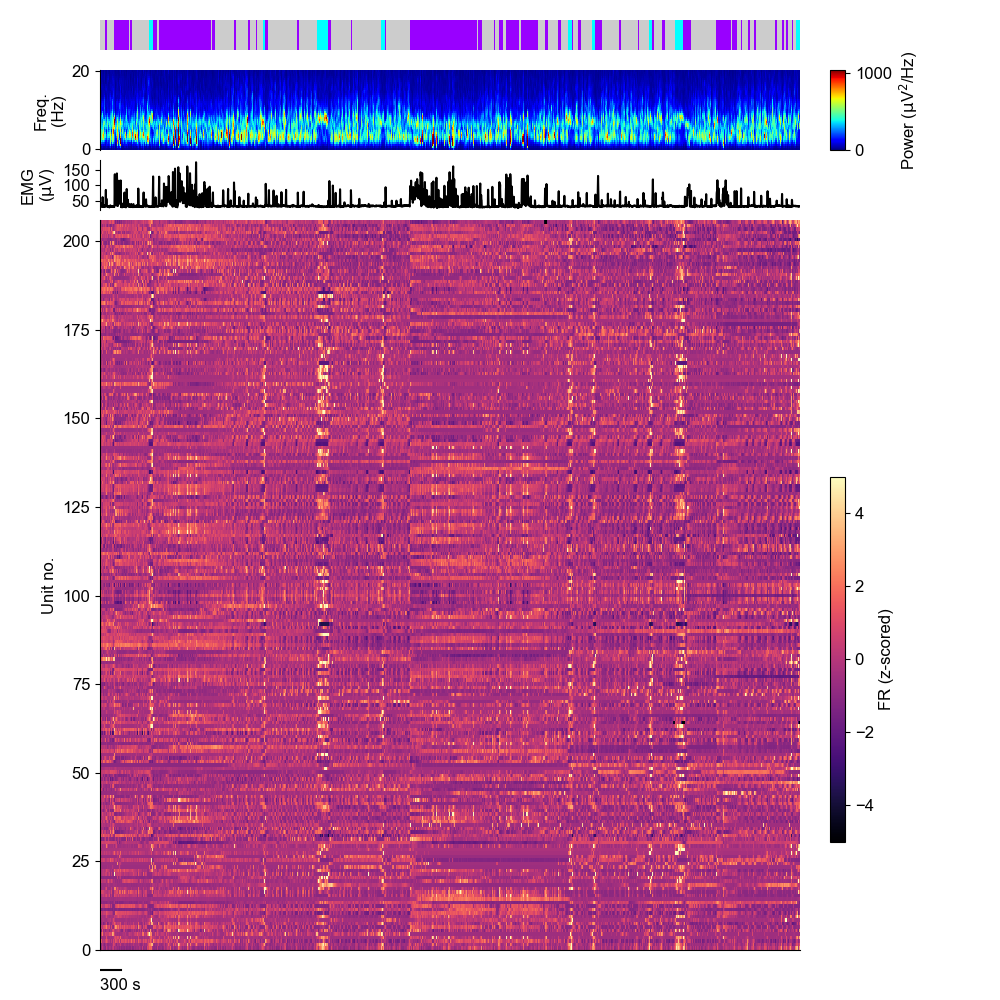

In [3]:
_ = nx.plot_firingrates_map(units, cell_info, ids, mouse, config_file, kcuts=kcut, pzscore=True,
                            nsmooth=1, pnorm_spec=False, box_filt=[3,4], vm_fr=[-5, 5], r_mu=[10,200])


## Calculate sleep PCs

(1) To focus PCA on sleep, we excluded long wake episodes, defined as bouts longer then `wake_dur`. 
Wake bouts, separated by less than 20 s were fused by setting `wake_break = 20`. Firing rates are smoothed using a Gaussian kernal with std `nsmooth`. To remove linear trends/drifts in the firing rates, set `detrend = True`. To z-score firing rates, set `pzscore = True`.

(2) PCs are unique up to the sign. Therefore to make sure that PCs have the same 'orientation' across mice, we
first compute PCs, then determine the sign of PC1 and PC2 to make sure, PC1 is 'REM-active' (positive average amplitude during REM) and PC2 is positively aligned with the EEG sigma power. From PC3 on, PCs are aligned such that their average amplitude during REM is positive.

(3) Having the corrected PC signs, we then calculate again the PCs (we could have just multipled the PCs from (1) with the corresponding sign in `pc_sign`).

(4) Here, we approximate the firing rates just using the first two PCs (Fig. 3)

4060
4060


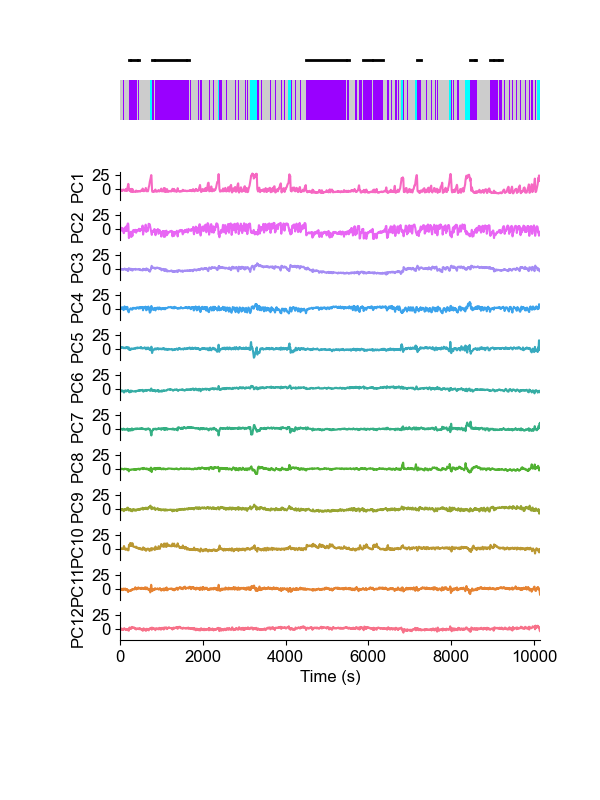

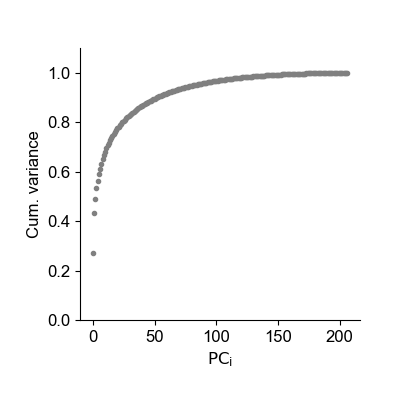

In [4]:
# Detrend data? 
# this can help if there's a slow 'linear' drift, shared by all units.
detrend = True
# show the first `ndim` PCs
ndim = 12
# z-score firing rates?
pzscore = True

# (1)
PC_tmp, V, Vh, idx = nx.sleep_components(units, M, ndim=ndim, nsmooth=nsmooth, wake_dur=60, 
                                         pzscore=pzscore, wake_break=20, pc_sign=np.ones((ndim,)),
                                         kcuts=kcut, detrend=detrend, 
                                         mouse=mouse, config_file=config_file, pplot=False)
# (2)
# get corrected pc_sign
pc_sign = nx.align_pcsign(PC_tmp, mouse, config_file=config_file, kcuts=kcut)

# (3)
# and then run again nx.sleep_components with the corrected parameters for pc_sign
sleepy.set_fontsize(12)
PC, V, Vh, idx = nx.sleep_components(units, M, ndim=ndim, nsmooth=nsmooth, wake_dur=60, 
                                     pc_sign=pc_sign, pzscore=pzscore, wake_break=20, 
                                     kcuts=kcut, detrend=detrend, ylim=[-20, 30], mouse=mouse, 
                                     config_file=config_file, pplot=True, collapse=False)

fig_nums = plt.get_fignums()
# get the first of the two figures:
first_fig = plt.figure(fig_nums[-2])
first_fig.set_size_inches(6, 8)
first_fig.canvas.draw()

# (4)
# reconstruction of firing rates using PCs
C, df_coeff, _, _ = nx.pc_reconstruction2(units, cell_info, time_idx=idx, ndim=2, nsmooth=nsmooth, 
                                    pnorm=False, pzscore=True, pearson=True, 
                                    pc_sign=pc_sign[0:2], kcuts=kcut, detrend=detrend, pplot=False, sign_plot=False)



The first figure shows the hypnogram (violet - Wake, gray - NREM, cyan - REM). The black lines on top of the hypnogram indicate intervals that were excluded from the PC computation. 

The second plot shows the (non-cross validated) total variance by increasing numbers of PCs.

## State space analysis

(1) To construct the 2D state space (see Fig. 2), we plot PC1 against PC2 using the function `nx.pc_state_space`. 
Noteworthy parameters:
* `ma_thr`: Microsarousal threshods, i.e. Wake episodes with duration < ma_thr are interpreted as NREM.
* `outline_std`: If True, draw for each brain state an ellipse capturing x % of the distribution of data points in this state.
* `scale`: Dertermines the percentile of how much data the ellipse includes. Setting `scale == 1.645`, the ellipses include 90% of the data (within each state). 


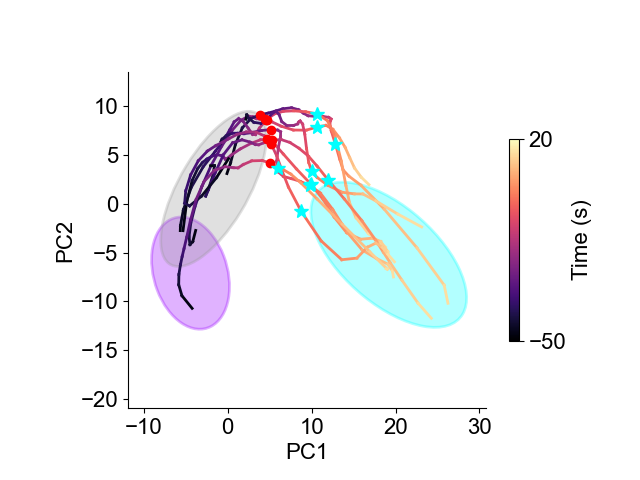

In [17]:
ma_thr=20
outline_std = True
sleepy.set_fontsize(16)
scale = 1.645

ax = nx.pc_state_space(PC, M, ma_thr=ma_thr, rem_onset=True, 
                       pscatter=False, outline_std=True, break_out=True, 
                       scale=scale, pre_win=50, post_win=20)[0]


The figure shows all NREM->REM transitions raning from 50s before to 20s after the transition. Time is colorcoded along the trajectories. Red dots indicates the point where the trajectories left the NREM subspace. Stars indicate where the annotator set the onset of REM sleep based on EEG/EMG signals.

## Distribution of PC coefficients

We approximated the firing rates of each unit i as

fr_i(t) = c1_i * PC1(t) + c2_i * PC2(t)

The set of coefficients [c1_i, c2_i] thus provides a 2D description of the firing rate dynamics. 

The following figure shows the distribution1 of c1 and c2 across different brain areas:

In [47]:
df_coeff_reg = df_coeff.merge(cell_info[['ID', 'brain_region', 'lateral']], on='ID', how='left')
df_coeff_reg['brain_region'].fillna('X', inplace=True)


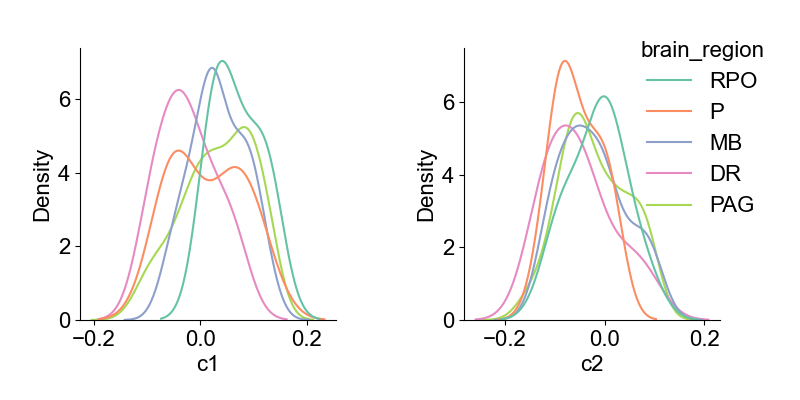

In [92]:
fig, axs = plt.subplots(1,2, figsize=[8, 4])

g = sns.kdeplot(data=df_coeff_reg, x='c1', hue='brain_region', common_norm=False, palette='Set2', ax=axs[0])
g.legend_.remove()
sns.despine()
plt.subplots_adjust(left=0.2, bottom=0.2, right=0.8, wspace=0.5)

sns.kdeplot(data=df_coeff_reg, x='c2', hue='brain_region', common_norm=False, palette='Set2', ax=axs[1])
sns.despine()
plt.subplots_adjust(left=0.1, bottom=0.2, right=0.9, wspace=0.5)

legend = plt.gca().get_legend()
legend.set_frame_on(False)
legend.set_loc('upper right')
legend.set_bbox_to_anchor([1.25, 1.1])


In [39]:
alpha = 0.05
df_coeff_typ = df_coeff_reg.copy()

df_coeff_typ['cond'] = 'X'
df_coeff_typ.loc[(df_coeff_typ.p1 < alpha) & (df_coeff_typ.p2 < alpha) & (df_coeff_typ.c1<0) & (df_coeff_typ.c2<0),'cond'] = 'c1-c2-'
df_coeff_typ.loc[(df_coeff_typ.p1 < alpha) & (df_coeff_typ.p2 < alpha) & (df_coeff_typ.c1>0) & (df_coeff_typ.c2<0),'cond'] = 'c1+c2-'
df_coeff_typ.loc[(df_coeff_typ.p1 < alpha) & (df_coeff_typ.p2 < alpha) & (df_coeff_typ.c1>0) & (df_coeff_typ.c2>0),'cond'] = 'c1+c2+'
df_coeff_typ.loc[(df_coeff_typ.p1 < alpha) & (df_coeff_typ.p2 < alpha) & (df_coeff_typ.c1<0) & (df_coeff_typ.c2>0),'cond'] = 'c1-c2+'

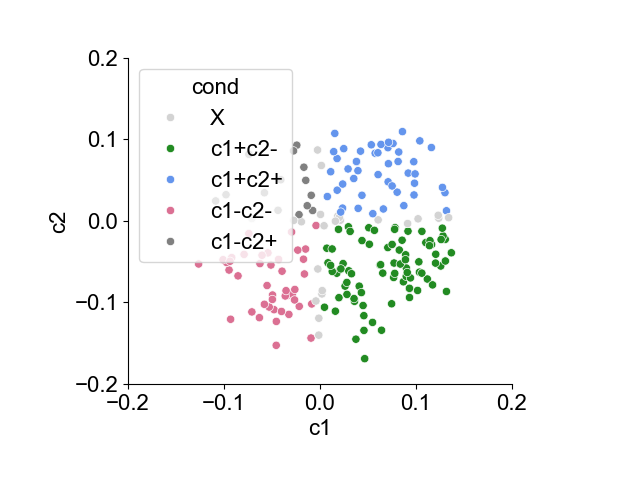

In [46]:
palette_dict = {'c1+c2-':'forestgreen', 'c1+c2+':'cornflowerblue', 'c1-c2+':'gray', 'X':'beige', 'c1-c2-':'palevioletred'}
palette_dict['X'] = 'lightgray'

sleepy.set_fontsize(16)
plt.figure()
sns.scatterplot(data=df_coeff_typ, x='c1', y='c2', hue='cond', palette=palette_dict)
plt.xlim([-0.2, 0.2])
plt.ylim([-0.2, 0.2])
sns.despine()
plt.subplots_adjust(left=0.2, bottom=0.2, right=0.8)


## Infraslow tuning of PCs

Calculate for each PC its power at the infraslow frequency, defined as the frequency at which the EEG sigma power peaks.

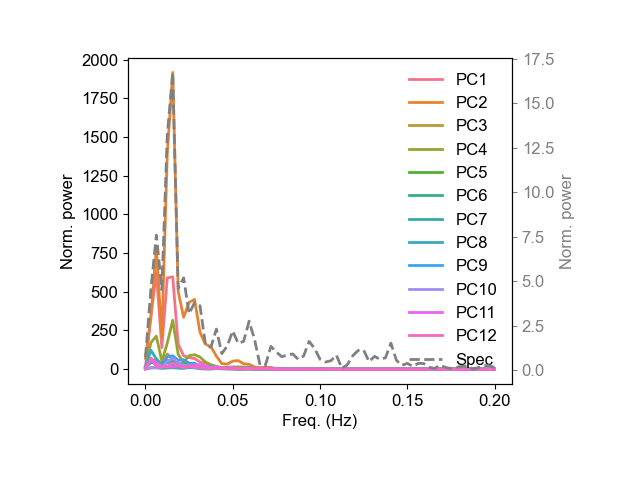

In [32]:
sleepy.set_fontsize(12)
_=nx.pc_infraslow(PC, M, mouse, kcuts=kcut, dt=2.5, nsmooth=0, ma_thr=20, 
                 ma_rem_exception=False, ma_mode=True, kcut=[], state=3, peeg2=False,
                 band=[10,15], min_dur=120, win=128, config_file=config_file, 
                 pnorm=False, spec_norm=True, spec_filt=False, box=[1,4], pplot=True)